# Project: Book Rating Prediction Model

In [64]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression 
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

## 1. Load dataset

In [65]:
# raise a warning when a bad line (a line with too many fields) is encountered and skip that line
df = pd.read_csv("books.csv", on_bad_lines='warn')

Skipping line 3350: expected 12 fields, saw 13
Skipping line 4704: expected 12 fields, saw 13
Skipping line 5879: expected 12 fields, saw 13
Skipping line 8981: expected 12 fields, saw 13



In [66]:
df.head()

,bookID,title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,text_reviews_count,publication_date,publisher
0,1,Harry Potter and the Half-Blood Prince (Harry ...,J.K. Rowling/Mary GrandPré,4.57,0439785960,9780439785969,eng,652,2095690,27591,9/16/2006,Scholastic Inc.
1,2,Harry Potter and the Order of the Phoenix (Har...,J.K. Rowling/Mary GrandPré,4.49,0439358078,9780439358071,eng,870,2153167,29221,9/1/2004,Scholastic Inc.
2,4,Harry Potter and the Chamber of Secrets (Harry...,J.K. Rowling,4.42,0439554896,9780439554893,eng,352,6333,244,11/1/2003,Scholastic
3,5,Harry Potter and the Prisoner of Azkaban (Harr...,J.K. Rowling/Mary GrandPré,4.56,043965548X,9780439655484,eng,435,2339585,36325,5/1/2004,Scholastic Inc.
4,8,Harry Potter Boxed Set Books 1-5 (Harry Potte...,J.K. Rowling/Mary GrandPré,4.78,0439682584,9780439682589,eng,2690,41428,164,9/13/2004,Scholastic


## 2. Dataset analysis

In [67]:
df.describe()

,bookID,average_rating,isbn13,num_pages,ratings_count,text_reviews_count
count,11123.000000,11123.000000,1.112300e+04,11123.000000,1.112300e+04,11123.000000
mean,21310.856963,3.934075,9.759880e+12,336.405556,1.794285e+04,542.048099
std,13094.727252,0.350485,4.429758e+11,241.152626,1.124992e+05,2576.619589
min,1.000000,0.000000,8.987060e+09,0.000000,0.000000e+00,0.000000
25%,10277.500000,3.770000,9.780345e+12,192.000000,1.040000e+02,9.000000
50%,20287.000000,3.960000,9.780582e+12,299.000000,7.450000e+02,47.000000
75%,32104.500000,4.140000,9.780872e+12,416.000000,5.000500e+03,238.000000
max,45641.000000,5.000000,9.790008e+12,6576.000000,4.597666e+06,94265.000000


#### Data distribution

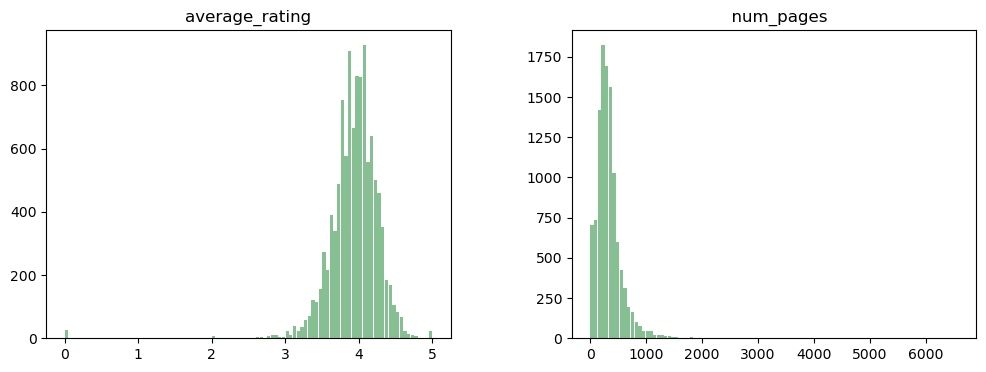

In [68]:
df.hist(column=["average_rating", "  num_pages"], 
        bins=100, grid=False, figsize=(12,4), color='#86bf91', rwidth=0.9)
plt.show()

#### Plotting each dimension against the target

In [69]:
df[["  num_pages", "average_rating", "ratings_count"]].corr()

,num_pages,average_rating,ratings_count
num_pages,1.000000,0.150477,0.034337
average_rating,0.150477,1.000000,0.038224
ratings_count,0.034337,0.038224,1.000000


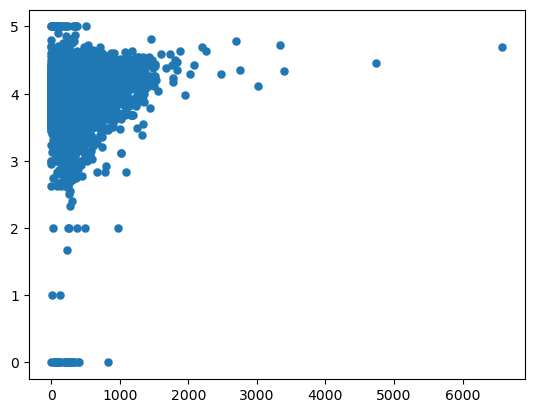

In [70]:
plt.scatter(df["  num_pages"], df["average_rating"], linewidths=0.1)

In [71]:
(df['average_rating'] < 1).sum()

25

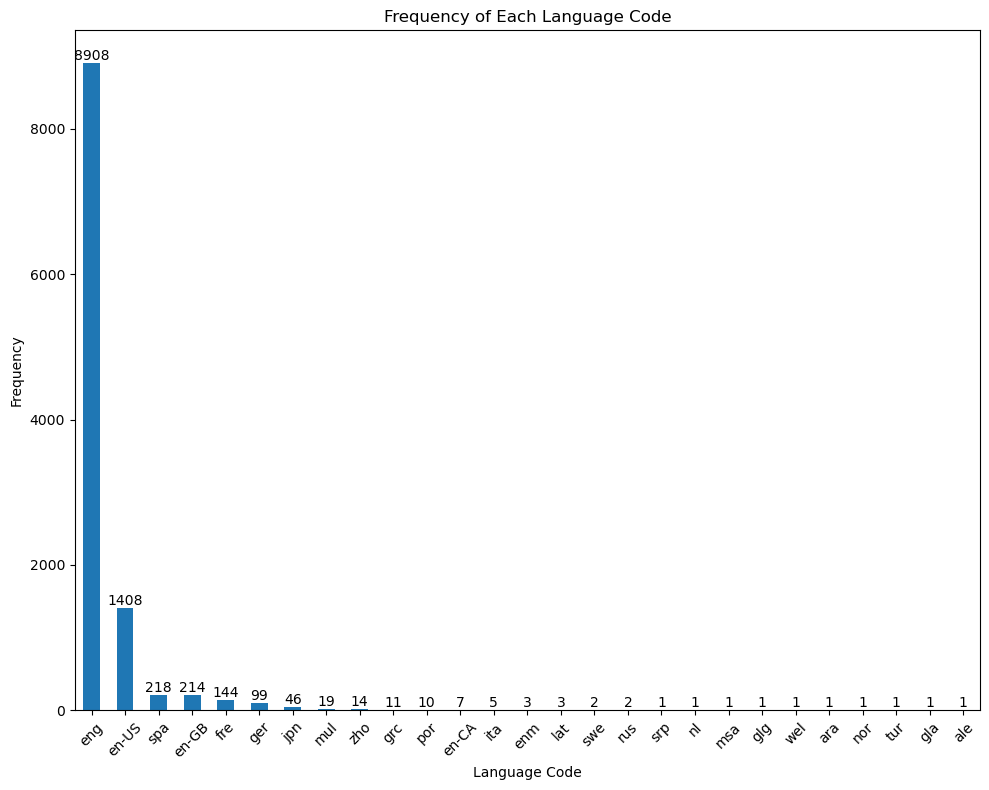

In [72]:
# Counting the frequency of each language code
language_counts = df['language_code'].value_counts()

# Creating a bar chart for the language codes
plt.figure(figsize=(10, 8))
language_counts.plot(kind='bar')
plt.title('Frequency of Each Language Code')
plt.xlabel('Language Code')
plt.ylabel('Frequency')
plt.xticks(rotation=45)

for i in range(len(language_counts)):
    plt.text(i, language_counts[i], str(language_counts[i]), ha='center', va='bottom')
    
plt.tight_layout()

## 3 Pre-Processing

#### Removing irrelevant feature

In [73]:
df = df.drop(['bookID', 'title', 'isbn', 'isbn13'], axis = 1)

#### Exclude languages with fewer than 99 books from the dataset

In [74]:
df['language_code'].replace({'en-US':'eng', 'en-GB':'eng', 'en-CA':'eng'}, inplace=True)
language_counts = df['language_code'].value_counts()
df = df[~df['language_code'].isin(language_counts[language_counts < 99].index)]

In [75]:
df['language_code'].value_counts()

language_code
eng    10537
spa      218
fre      144
ger       99
Name: count, dtype: int64

#### Removing unnecessary spaces

In [76]:
df.rename(columns=lambda x: x.strip(), inplace=True)

#### Filter out books that have received too few ratings

In [77]:
df.query("ratings_count >= 20", inplace=True)

In [78]:
df.describe()

,average_rating,num_pages,ratings_count,text_reviews_count
count,9941.000000,9941.000000,9.941000e+03,9941.000000
mean,3.947065,343.476612,2.006989e+04,606.212956
std,0.271735,240.175589,1.188209e+05,2718.392407
min,2.400000,0.000000,2.000000e+01,0.000000
25%,3.780000,206.000000,2.080000e+02,16.000000
50%,3.960000,304.000000,1.101000e+03,65.000000
75%,4.130000,419.000000,6.253000e+03,293.000000
max,4.820000,6576.000000,4.597666e+06,94265.000000


In [79]:
def preprocess_author_name(author_name):
    # Remove spaces in the author's name and delete characters before the '/'
    return author_name.replace(" ", "").split("/")[0]

df['authors'] = df['authors'].apply(lambda x: preprocess_author_name(x))

In [80]:
df.nunique()

authors               3732
average_rating         191
language_code            4
num_pages              979
ratings_count         5269
text_reviews_count    1822
publication_date      3381
publisher             1919
dtype: int64

#### Date encoding

In [81]:
df['publication_date'] = pd.to_datetime(df['publication_date'], format='%m/%d/%Y', errors='coerce')

In [82]:
print(len(df[df['publication_date'].isnull()]))

1


In [83]:
df.dropna(subset=['publication_date'], inplace=True)
df['publication_date'] = df['publication_date'].apply(lambda x: x.timestamp())

In [84]:
def binary_encoder(df, column_name):
    encoder = preprocessing.OneHotEncoder(sparse_output=False, handle_unknown='ignore')
    encoded = encoder.fit_transform(df[[column_name]])
    encoded_column_name = encoder.get_feature_names_out([column_name])
    encoded_df = pd.DataFrame(encoded, columns=encoded_column_name)
    df = pd.concat([df.reset_index(drop=True), encoded_df], axis=1)
    df.drop(column_name, axis=1, inplace=True)
    return df

In [85]:
# df = binary_encoder(df, 'publisher')
df = binary_encoder(df, 'authors')
df = binary_encoder(df, 'language_code')
df.head()

,average_rating,num_pages,ratings_count,text_reviews_count,publication_date,publisher,authors_A.B.Yehoshua,authors_A.J.Jacobs,authors_A.M.Homes,authors_A.N.Roquelaure,...,authors_ZoraNealeHurston,authors_ZoëHeller,authors_bellhooks,authors_ÅsneSeierstad,authors_ÉmileZola,authors_Éric-EmmanuelSchmitt,language_code_eng,language_code_fre,language_code_ger,language_code_spa
0,4.57,652,2095690,27591,1.158365e+09,Scholastic Inc.,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,4.49,870,2153167,29221,1.093997e+09,Scholastic Inc.,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,4.42,352,6333,244,1.067645e+09,Scholastic,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,4.56,435,2339585,36325,1.083370e+09,Scholastic Inc.,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,4.78,2690,41428,164,1.095034e+09,Scholastic,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


#### Cleaned dataset

In [86]:
df.to_csv('books_cleaned.csv', index=False)

## Linear regression

In [87]:
X = df.drop(['average_rating', 'publisher'], axis = 1)
y = df['average_rating']
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2)
linReg = LinearRegression()
linReg.fit(X_train, y_train)

LinearRegression()

In [88]:
y_pred = linReg.predict(X_test)

In [89]:
print('Mean Absolute Error (MAE):', mean_absolute_error(y_test, y_pred))
print('Mean Squared Error (MSE):', mean_squared_error(y_test, y_pred))
print("Coefficient de détermination (R-squared) :", r2_score(y_test, y_pred))

Mean Absolute Error (MAE): 0.17003853917027162
Mean Squared Error (MSE): 0.052585253192706086
Coefficient de détermination (R-squared) : 0.29340842784631627


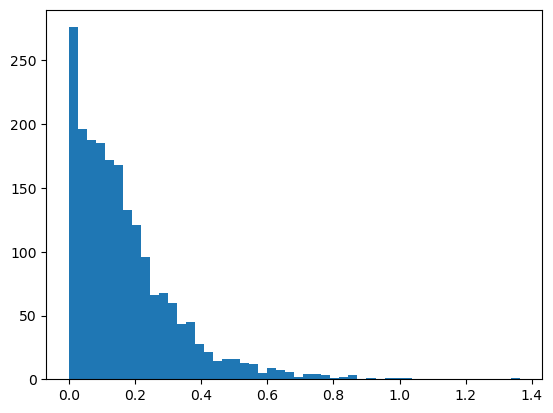

In [90]:
err_hist = np.abs(y_test-y_pred)
plt.hist(err_hist, bins=50)
plt.show()

## Decision Tree

In [91]:
from sklearn.ensemble import RandomForestRegressor


# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialiser et entraîner le modèle
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Faire des prédictions sur l'ensemble de test
y_pred = model.predict(X_test)

# Évaluer le modèle
print('Mean Absolute Error (MAE):', mean_absolute_error(y_test, predictions))
print('Mean Squared Error (MSE):', mean_squared_error(y_test, predictions))
print("Coefficient de détermination (R-squared) :", r2_score(y_test, y_pred))

Mean Absolute Error (MAE): 0.18966272635814888
Mean Squared Error (MSE): 0.06138109187625757
Coefficient de détermination (R-squared) : 0.2099334577776537


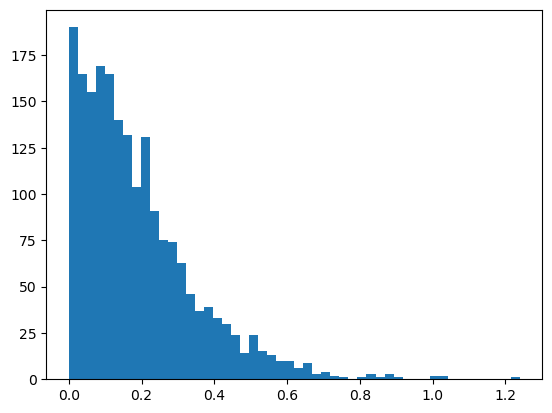

In [92]:
err_hist = np.abs(y_test-y_pred)
plt.hist(err_hist, bins=50)
plt.show()

In [ ]:
err_hist = np.abs(y_test-y_pred)
plt.hist(err_hist, bins=50)
plt.show()

## Neural network